In [1]:
import os
import sys

import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.utils import make_grid
import torchvision.transforms as TF
from PIL import Image

sys.path.insert(0, os.path.abspath(os.path.join("..", "..", "src")))

from ddpm.unet import UNet
from ddpm.helpers import get_default_device, inverse_transform
from dataclasses import dataclass
from ddpm.datasets import get_dataloader
from ddpm.diffusion import SimpleDiffusion, forward_diffusion, reverse_diffusion

# Configurations

In [2]:
@dataclass
class BaseConfig:
    DEVICE = get_default_device()
    DATASET = "MNIST"  #  "MNIST", "Cifar-10", "Cifar-100", "Flowers"

    # For logging inferece images and saving checkpoints.
    root_log_dir = os.path.join("..", "..", "local_data", "ddpm", "inference")
    root_checkpoint_dir = os.path.join("..", "..", "local_data", "ddpm", "checkpoints")

    # Current log and checkpoint directory.
    log_dir = "version_0"
    checkpoint_dir = "version_0"


@dataclass
class TrainingConfig:
    TIMESTEPS = 1000  # Define number of diffusion timesteps
    IMG_SHAPE = (1, 32, 32) if BaseConfig.DATASET == "MNIST" else (3, 32, 32)
    NUM_EPOCHS = 30
    BATCH_SIZE = 128
    LR = 2e-4
    NUM_WORKERS = 2

# Load Dataset & Build Dataloader

In [3]:
loader = get_dataloader(
    dataset_name=BaseConfig.DATASET,
    batch_size=64,
    device="cpu",
    root_dir=os.path.join("..", "..", "local_data"),
)

-1.1543515 1.205056


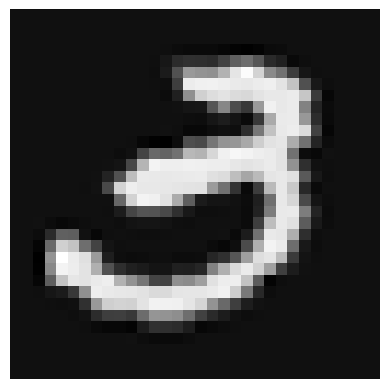

In [4]:
sample_image = next(iter(loader))[0][0, 0]
# sample_image = inverse_transform(sample_image) / 255.0
print(sample_image.min().numpy(), sample_image.max().numpy())

_ = plt.imshow(sample_image, cmap="gray")
_ = plt.axis("off")

torch.Size([3, 133, 529]) tensor(0.) tensor(1.)


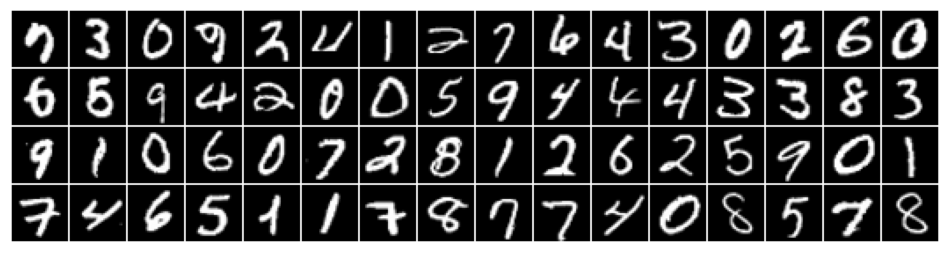

In [5]:
plt.figure(figsize=(12, 6), facecolor="white")

for b_image, _ in loader:
    b_image = inverse_transform(b_image).cpu()
    grid_img = make_grid(
        b_image / 255.0,
        nrow=16,
        padding=True,
        pad_value=1,
        normalize=True,
    )
    print(grid_img.shape, grid_img.min(), grid_img.max())
    plt.imshow(grid_img.permute(1, 2, 0), cmap="gray")
    plt.axis("off")
    break

# Visualize Forward Diffusion Process

In [6]:
sd = SimpleDiffusion(
    num_diffusion_timesteps=TrainingConfig.TIMESTEPS,
    device="cpu",
    img_shape=TrainingConfig.IMG_SHAPE,
)

# converting dataloader into an iterator for now.
loader = iter(
    get_dataloader(
        dataset_name=BaseConfig.DATASET,
        batch_size=6,
        device="cpu",
        root_dir=os.path.join("..", "..", "local_data"),
    )
)
x0s, _ = next(loader)

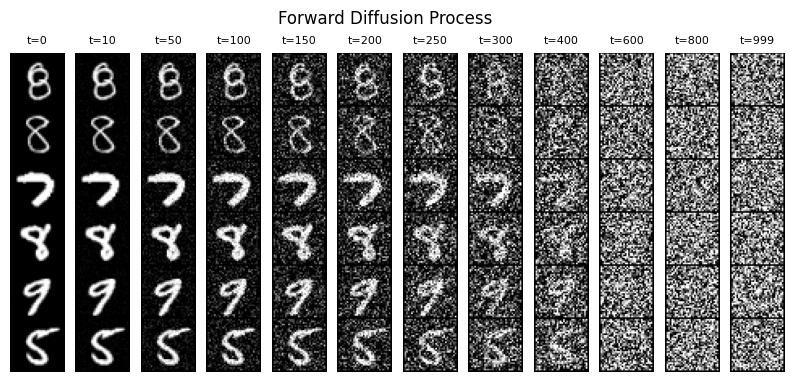

In [7]:
noisy_images = []
specific_timesteps = [0, 10, 50, 100, 150, 200, 250, 300, 400, 600, 800, 999]

for timestep in specific_timesteps:
    timestep = torch.as_tensor(timestep, dtype=torch.long)

    xts, _ = forward_diffusion(sd, x0s, timestep)
    xts = inverse_transform(xts) / 255.0
    xts = make_grid(xts, nrow=1, padding=1)

    noisy_images.append(xts)

# Plot and see samples at different timesteps

_, ax = plt.subplots(1, len(noisy_images), figsize=(10, 5), facecolor="white")

for i, (timestep, noisy_sample) in enumerate(zip(specific_timesteps, noisy_images)):
    ax[i].imshow(noisy_sample.squeeze(0).permute(1, 2, 0))
    ax[i].set_title(f"t={timestep}", fontsize=8)
    ax[i].axis("off")
    ax[i].grid(False)

plt.suptitle("Forward Diffusion Process", y=0.9)
plt.axis("off")
plt.show()

# Visualize Reverse Diffusion Process

In [8]:
unet = UNet(
    input_channels=TrainingConfig.IMG_SHAPE[0],
    output_channels=TrainingConfig.IMG_SHAPE[0],
    base_channels=64,  # 64, 128, 256, 512
    base_channels_multiples=[1, 2, 4, 8],  # 32, 16, 8, 4
    apply_attention=[False, False, True, False],
    dropout_rate=0.1,
    time_multiple=2,  # 64 -> 128
)

# load checkpoint if available
checkpoint_path = os.path.join(BaseConfig.root_checkpoint_dir, "version_0", "ckpt.tar")

if os.path.exists(checkpoint_path):
    print("Loading checkpoint...")
    checkpoint = torch.load(checkpoint_path)
    unet.load_state_dict(checkpoint["model"])
    print("Checkpoint loaded successfully!")
else:
    print("Checkpoint not found!")

Loading checkpoint...


Checkpoint loaded successfully!


In [9]:
x_0_gen, steps = reverse_diffusion(
    deep_model=unet,
    diffusion_model=sd,
    img_shape=TrainingConfig.IMG_SHAPE,
    num_images=16,
    device="cuda:1",
    timesteps=1000,
    record_process=True,
)


Sampling :: 100%|██████████| 999/999 [00:27<00:00, 35.91it/s]


In [10]:
x_0_gen_inv = inverse_transform(x_0_gen).type(torch.uint8)
grid = torchvision.utils.make_grid(x_0_gen_inv, nrow=4, pad_value=255.0).to("cpu")
pil_image = TF.functional.to_pil_image(grid)

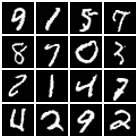

In [11]:
display(pil_image)